In [1]:
# @title Import Files

!pip install kaggle

# Upload kaggle.json
from google.colab import files
files.upload()  # This will prompt you to upload the kaggle.json file

# Create the .kaggle directory
!mkdir -p ~/.kaggle

# Move the kaggle.json file to the .kaggle directory
!cp kaggle.json ~/.kaggle/

# Set the permissions
!chmod 600 ~/.kaggle/kaggle.json

# Verify the kaggle.json file is in the correct location
!ls ~/.kaggle

# Download the dataset from Kaggle
!kaggle datasets download -d humansintheloop/semantic-segmentation-of-aerial-imagery

# Extract the dataset
import zipfile
import os

zip_file_path = '/content/semantic-segmentation-of-aerial-imagery.zip'
extract_to_path = '/content/semantic-segmentation-of-aerial-imagery/'

os.makedirs(extract_to_path, exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to_path)

print('Dataset extracted successfully')

# Verify the extraction
extracted_files = os.listdir(extract_to_path)
print(extracted_files)

Saving kaggle.json to kaggle.json
kaggle.json
Dataset URL: https://www.kaggle.com/datasets/humansintheloop/semantic-segmentation-of-aerial-imagery
License(s): CC0-1.0
100% 29.6M/29.6M [00:02<00:00, 17.2MB/s]
100% 29.6M/29.6M [00:02<00:00, 10.7MB/s]
Dataset extracted successfully
['Semantic segmentation dataset']


In [2]:
!pip install patchify

In [3]:
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt
from patchify import patchify
from PIL import Image
import torch
from sklearn.preprocessing import MinMaxScaler,StandardScaler

# Semantic Segmentation of Aereal images of Earth with SegNet

In [4]:
def create_dir(dir_name):
    if not os.path.exists(dir_name):
        os.makedirs(dir_name, exist_ok=True)

In [5]:
scaler = MinMaxScaler()
root_dir = '/content/semantic-segmentation-of-aerial-imagery/Semantic segmentation dataset/'
patch_size = 256

In [6]:
image_dataset=[]
for path, subdirs, files in os.walk(root_dir):
    dirname = path.split(os.path.sep)[-1]
    if dirname == "images":
        images = sorted(os.listdir(path))  # Sorting the list of image files
        for i, image_name in enumerate(images):
            if image_name.endswith(".jpg"):
                image_path = os.path.join(path, image_name)
                image = cv2.imread(image_path, cv2.IMREAD_COLOR)

                SIZE_X = (image.shape[1]//patch_size)*patch_size
                SIZE_Y = (image.shape[0]//patch_size)*patch_size
                image = Image.fromarray(image)
                image = image.crop((0,0,SIZE_X,SIZE_Y))

                image = np.array(image)

                patches_img = patchify(image,(patch_size,patch_size,3),step=patch_size)
                for i in range(patches_img.shape[0]):
                    for j in range(patches_img.shape[1]):
                        single_patch_img = patches_img[i,j,:,:]
                        # img need flatten
                        single_patch_img = scaler.fit_transform(single_patch_img.reshape(-1, single_patch_img.shape[-1])).reshape(single_patch_img.shape)
                        single_patch_img = single_patch_img[0] #Drop the extra unecessary dimension that patchify adds.
                        image_dataset.append(single_patch_img)


mask_dataset =[]
for path, subdirs, files in os.walk(root_dir):
    dirname = path.split(os.path.sep)[-1]
    if dirname == "masks":
        masks = sorted(os.listdir(path))  # Sorting the list of mask files
        for i, mask_name in enumerate(masks):
            if mask_name.endswith(".png"):
                mask_path = os.path.join(path, mask_name)
                mask = cv2.imread(mask_path, 1)
                mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
                SIZE_X = (mask.shape[1]//patch_size)*patch_size
                SIZE_Y = (mask.shape[0]//patch_size)*patch_size
                mask = Image.fromarray(mask)
                mask = mask.crop((0,0,SIZE_X,SIZE_Y))
                mask = np.array(mask)

                patches_mask = patchify(mask,(patch_size,patch_size,3),step = patch_size)

                for i in range(patches_mask.shape[0]):
                    for j in range(patches_mask.shape[1]):
                        single_patch_mask = patches_mask[i,j,:,:]
                        single_patch_mask = single_patch_mask[0]
                        mask_dataset.append(single_patch_mask)

In [7]:
image_dataset =np.asarray(image_dataset)
mask_dataset =np.asarray(mask_dataset)
image_dataset.shape

(1305, 256, 256, 3)

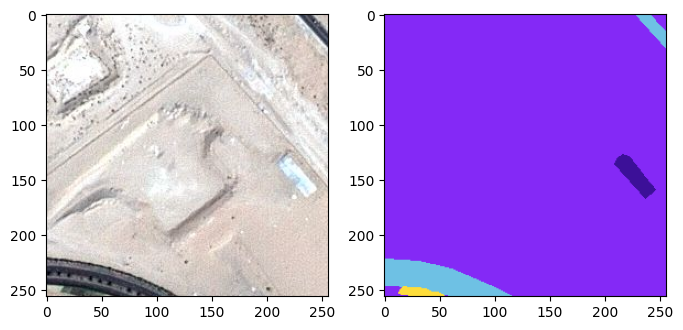

In [8]:
import random
import numpy as np
image_number = random.randint(0,len(image_dataset))
plt.figure(figsize=(8, 4))
plt.subplot(121)
plt.imshow(np.reshape(image_dataset[image_number], (patch_size, patch_size, 3)))
plt.subplot(122)
plt.imshow(np.reshape(mask_dataset[image_number], (patch_size, patch_size, 3)))
plt.show()

In [9]:
Building = '#3C1098'.lstrip('#')
Building = np.array(tuple(int(Building[i:i+2], 16) for i in (0, 2, 4))) # 60, 16, 152

Land = '#8429F6'.lstrip('#')
Land = np.array(tuple(int(Land[i:i+2], 16) for i in (0, 2, 4))) #132, 41, 246

Road = '#6EC1E4'.lstrip('#')
Road = np.array(tuple(int(Road[i:i+2], 16) for i in (0, 2, 4))) #110, 193, 228

Vegetation =  'FEDD3A'.lstrip('#')
Vegetation = np.array(tuple(int(Vegetation[i:i+2], 16) for i in (0, 2, 4))) #254, 221, 58

Water = 'E2A929'.lstrip('#')
Water = np.array(tuple(int(Water[i:i+2], 16) for i in (0, 2, 4))) #226, 169, 41

Unlabeled = '#9B9B9B'.lstrip('#')
Unlabeled = np.array(tuple(int(Unlabeled[i:i+2], 16) for i in (0, 2, 4))) #155, 155, 155

In [10]:
def rgb_to_2D_label(label,num_class=6):
    """
    Suply our labale masks as input in RGB format.
    Replace pixels with specific RGB values ...
    """
    label_seg = np.zeros(label.shape,dtype=np.uint8)
    label_seg [np.all(label == Building,axis=-1)] = 0
    label_seg [np.all(label==Land,axis=-1)] = 1
    label_seg [np.all(label==Road,axis=-1)] = 2
    label_seg [np.all(label==Vegetation,axis=-1)] = 3
    label_seg [np.all(label==Water,axis=-1)] = 4
    label_seg [np.all(label==Unlabeled,axis=-1)] = 5

    label_seg = label_seg[:,:,0]  #Just take the first channel, no need for all 3 channels


    new_label = np.zeros(label_seg.shape + (num_class,))


    for i in range(num_class):
        new_label[label_seg == i,i] = 1
    label_seg=new_label

    return label_seg

In [11]:
labels = []
for i in range(mask_dataset.shape[0]):
    label = rgb_to_2D_label(mask_dataset[i])
    labels.append(label)


labels = np.array(labels)


print("Unique labels in label dataset are: ", np.unique(labels))

Unique labels in label dataset are:  [0. 1.]


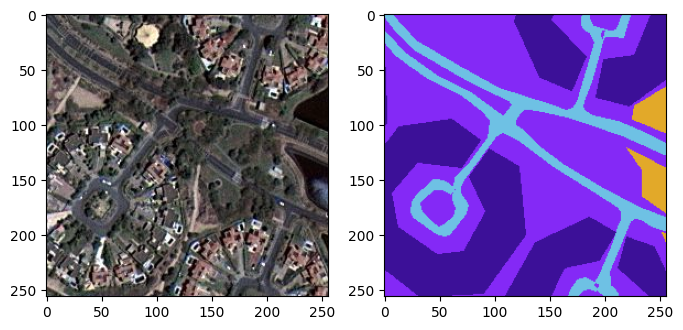

In [12]:
image_number = random.randint(0,len(image_dataset))
plt.figure(figsize=(8, 4))
plt.subplot(121)
plt.imshow(np.reshape(image_dataset[image_number], (patch_size, patch_size, 3)))
plt.subplot(122)
plt.imshow(np.reshape(mask_dataset[image_number], (patch_size, patch_size, 3)))
plt.show()

In [18]:
import torch.nn as nn
from torch.utils.data import DataLoader,Dataset

class Aerial(Dataset):
    def __init__(self, images, masks, transform=None):
        super(Aerial, self).__init__()
        self.images = images
        self.masks = masks
        self.transform = transform
        self.n_samples = len(images)

    def __getitem__(self, index):
        image = self.images[index]
        image = image / 255.0
        image = np.transpose(image, (2, 0, 1))
        image = image.astype(np.float32)
        image = torch.from_numpy(image)

        if self.transform:
            image = self.transform(image)

        mask = self.masks[index]
        mask = np.transpose(mask, (2, 0, 1))
        mask = mask.astype(np.float32)
        mask = torch.from_numpy(mask)

        return image, mask

    def __len__(self):
        return self.n_samples

In [14]:
create_dir("files/")
create_dir("Results/")
H = 256
W = 256
num_class = 6
size =(H,W)
batch_size = 2
num_epochs = 50
lr=1e-4
checkpoints_path ="files/checkpoints.pth"

In [19]:
from sklearn.model_selection import train_test_split
import torchvision.transforms as transforms

# Color shift and blurriness transformations
color_shift = transforms.ColorJitter(.1, .1, .1, .1)
blurriness = transforms.GaussianBlur(3, sigma=(0.1, 2.0))

t = transforms.Compose([color_shift, blurriness])

# Split dataset
train_x, val_x, train_y, val_y = train_test_split(image_dataset, labels, test_size=0.2, random_state=42)

train_dataset = Aerial(train_x, train_y, transform=t)
val_dataset = Aerial(val_x, val_y)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)


In [20]:
import torch.nn as nn
import torch
import torchvision

# Define SegNet model
class SegNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(SegNet, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2, return_indices=True)
        )
        self.decoder = nn.Sequential(
            nn.MaxUnpool2d(2, stride=2),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        size1 = x.size()
        x, indices = self.encoder(x)
        x = self.decoder[0](x, indices, output_size=size1)
        x = self.decoder[1:](x)
        return F.softmax(x, dim=1)


In [21]:
import torch
import torch.nn as nn

# Loss function and metrics
class DiceLoss(nn.Module):
    def __init__(self):
        super(DiceLoss, self).__init__()

    def forward(self, input, target):
        smooth = 1.0
        iflat = input.reshape(-1)
        tflat = target.reshape(-1)
        intersection = (iflat * tflat).sum()
        dice_loss = 1 - ((2.0 * intersection + smooth) / (iflat.sum() + tflat.sum() + smooth))
        return dice_loss

    def calculate_average_dice_loss(self, inputs, targets):
        num_channels = inputs.size(1)
        dice_losses = [self.forward(inputs[:, channel, ...].unsqueeze(1), targets[:, channel, ...].unsqueeze(1)) for channel in range(num_channels)]
        return torch.mean(torch.stack(dice_losses))

    def calculate_per_class_dice_loss(self, inputs, targets):
          num_channels = inputs.size(1)
          dice_losses = []
          for channel in range(num_channels):
              input_channel = inputs[:, channel, ...].unsqueeze(1)
              target_channel = targets[:, channel, ...].unsqueeze(1)
              dice_loss = self.forward(input_channel, target_channel)
              dice_losses.append(dice_loss.item())
          return dice_losses

def global_accuracy(output, target):
    with torch.no_grad():
        _, preds = torch.max(output, 1)
        preds = preds.view(-1)
        target = torch.argmax(target, dim=1).view(-1)
        correct = torch.eq(preds, target).sum().item()
        total = target.numel()
        accuracy = (correct / total) * 100
        return accuracy

class Recall(nn.Module):
    def __init__(self, epsilon=1e-5):
        super(Recall, self).__init__()
        self.epsilon = epsilon

    def forward(self, input, target):
        input = torch.sigmoid(input)
        true_positives = (input * target).sum(dim=(2, 3))
        actual_positives = target.sum(dim=(2, 3))
        recall = (true_positives + self.epsilon) / (actual_positives + self.epsilon)
        return recall.mean(dim=0)

    def calculate_mean_recall(self, inputs, targets):
        recalls = [self.forward(inputs[:, channel, ...].unsqueeze(1), targets[:, channel, ...].unsqueeze(1)) for channel in range(inputs.size(1))]
        return torch.stack(recalls).mean(dim=0)


In [22]:
# Metrics for each class
def per_class_accuracy(output, target, num_classes):
    with torch.no_grad():
        _, preds = torch.max(output, 1)
        preds = preds.view(-1)
        target = torch.argmax(target, dim=1).view(-1)
        accuracies = []
        for cls in range(num_classes):
            cls_mask = target == cls
            correct = torch.eq(preds[cls_mask], target[cls_mask]).sum().item()
            total = cls_mask.sum().item()
            if total > 0:
                accuracies.append((correct / total) * 100)  # Convert to percentage
            else:
                accuracies.append(0.0)
        return accuracies

class PerClassRecall(nn.Module):
    def __init__(self, num_classes, epsilon=1e-5):
        super(PerClassRecall, self).__init__()
        self.num_classes = num_classes
        self.epsilon = epsilon

    def forward(self, input, target):
        input = torch.sigmoid(input)
        recalls = []
        for cls in range(self.num_classes):
            true_positives = (input[:, cls, ...] * target[:, cls, ...]).sum(dim=(1, 2))
            actual_positives = target[:, cls, ...].sum(dim=(1, 2))
            recall = (true_positives + self.epsilon) / (actual_positives + self.epsilon)
            recalls.append(recall.mean().item())
        return recalls

In [23]:
model = SegNet(3, 6)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss_fn = DiceLoss()
recall_metric = Recall()
per_class_recall = PerClassRecall(num_classes=num_class)

In [25]:
# Training and validation functions with per-class metrics
def train(model, loader, loss_fn, optimizer, device, recall_metric):
    model.train()
    total_loss = 0
    total_dice_loss = np.zeros(num_class)
    total_recall = np.zeros(num_class)
    total_accuracy = np.zeros(num_class)
    avg_recall, avg_accuracy = 0, 0
    count = 0
    for x, y in loader:
        x = x.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        outputs = model(x)
        loss = loss_fn(outputs, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        per_class_dice = loss_fn.calculate_per_class_dice_loss(outputs, y)
        recalls = recall_metric(outputs, y)
        accuracies = per_class_accuracy(outputs, y, num_class)
        total_dice_loss += np.array(per_class_dice)
        total_recall += np.array(recalls)
        total_accuracy += np.array(accuracies)
        avg_recall += np.mean(recalls)
        avg_accuracy += np.mean(accuracies)
        count += 1
    return total_loss / count, avg_recall / count, avg_accuracy / count, total_recall / count, total_accuracy / count, total_dice_loss / count

def validate(model, loader, loss_fn, device, recall_metric):
    model.eval()
    total_loss = 0
    total_dice_loss = np.zeros(num_class)
    total_recall = np.zeros(num_class)
    total_accuracy = np.zeros(num_class)
    avg_recall, avg_accuracy = 0, 0
    count = 0
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)
            outputs = model(x)
            loss = loss_fn(outputs, y)
            total_loss += loss.item()
            per_class_dice = loss_fn.calculate_per_class_dice_loss(outputs, y)
            recalls = recall_metric(outputs, y)
            accuracies = per_class_accuracy(outputs, y, num_class)
            total_dice_loss += np.array(per_class_dice)
            total_recall += np.array(recalls)
            total_accuracy += np.array(accuracies)
            avg_recall += np.mean(recalls)
            avg_accuracy += np.mean(accuracies)
            count += 1
    return total_loss / count, avg_recall / count, avg_accuracy / count, total_recall / count, total_accuracy / count, total_dice_loss / count


from IPython.display import clear_output
import matplotlib.pyplot as plt
import torch.nn.functional as F

metrics = {
    "epoch": [],
    "train_loss": [],
    "val_loss": [],
    "train_recall": [],
    "val_recall": [],
    "train_accuracy": [],
    "val_accuracy": [],
    "train_recall_per_class": [],
    "val_recall_per_class": [],
    "train_accuracy_per_class": [],
    "val_accuracy_per_class": [],
    "train_dice_loss_per_class": [],
    "val_dice_loss_per_class": []
}

best_scores = {
    "train_loss": float('inf'),
    "val_loss": float('inf'),
    "train_recall": 0,
    "val_recall": 0,
    "train_accuracy": 0,
    "val_accuracy": 0,
    "train_dice_loss": np.ones(num_class) * float('inf'),
    "val_dice_loss": np.ones(num_class) * float('inf')
}

best_epochs = {
    "train_loss": 0,
    "val_loss": 0,
    "train_recall": 0,
    "val_recall": 0,
    "train_accuracy": 0,
    "val_accuracy": 0,
    "train_dice_loss": 0,
    "val_dice_loss": 0
}

best_score = float('inf')

for epoch in range(num_epochs):
    train_loss, train_avg_recall, train_avg_accuracy, train_recall_per_class, train_accuracy_per_class, train_dice_loss_per_class = train(model, train_loader, loss_fn, optimizer, device, per_class_recall)
    val_loss, val_avg_recall, val_avg_accuracy, val_recall_per_class, val_accuracy_per_class, val_dice_loss_per_class = validate(model, val_loader, loss_fn, device, per_class_recall)

    metrics["epoch"].append(epoch + 1)
    metrics["train_loss"].append(train_loss)
    metrics["val_loss"].append(val_loss)
    metrics["train_recall"].append(train_avg_recall)
    metrics["val_recall"].append(val_avg_recall)
    metrics["train_accuracy"].append(train_avg_accuracy)
    metrics["val_accuracy"].append(val_avg_accuracy)
    metrics["train_recall_per_class"].append(train_recall_per_class)
    metrics["val_recall_per_class"].append(val_recall_per_class)
    metrics["train_accuracy_per_class"].append(train_accuracy_per_class)
    metrics["val_accuracy_per_class"].append(val_accuracy_per_class)
    metrics["train_dice_loss_per_class"].append(train_dice_loss_per_class)
    metrics["val_dice_loss_per_class"].append(val_dice_loss_per_class)

    clear_output(wait=True)
    print(f'Epoch {epoch+1}/{num_epochs}')
    print(f'Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
    print(f'Train Avg Recall: {train_avg_recall:.4f}, Val Avg Recall: {val_avg_recall:.4f}')
    print(f'Train Avg Accuracy: {train_avg_accuracy:.4f}, Val Avg Accuracy: {val_avg_accuracy:.4f}')
    print(f'Train Recall per Class: {train_recall_per_class}')
    print(f'Val Recall per Class: {val_recall_per_class}')
    print(f'Train Accuracy per Class: {train_accuracy_per_class}')
    print(f'Val Accuracy per Class: {val_accuracy_per_class}')
    print(f'Train Dice Loss per Class: {train_dice_loss_per_class}')
    print(f'Val Dice Loss per Class: {val_dice_loss_per_class}')

    if train_loss < best_scores["train_loss"]:
        best_scores["train_loss"] = train_loss
        best_epochs["train_loss"] = epoch + 1
    if val_loss < best_scores["val_loss"]:
        best_scores["val_loss"] = val_loss
        best_epochs["val_loss"] = epoch + 1
    if train_avg_recall > best_scores["train_recall"]:
        best_scores["train_recall"] = train_avg_recall
        best_epochs["train_recall"] = epoch + 1
    if val_avg_recall > best_scores["val_recall"]:
        best_scores["val_recall"] = val_avg_recall
        best_epochs["val_recall"] = epoch + 1
    if train_avg_accuracy > best_scores["train_accuracy"]:
        best_scores["train_accuracy"] = train_avg_accuracy
        best_epochs["train_accuracy"] = epoch + 1
    if val_avg_accuracy > best_scores["val_accuracy"]:
        best_scores["val_accuracy"] = val_avg_accuracy
        best_epochs["val_accuracy"] = epoch + 1

    for i in range(num_class):
        if train_dice_loss_per_class[i] < best_scores["train_dice_loss"][i]:
            best_scores["train_dice_loss"][i] = train_dice_loss_per_class[i]
            best_epochs["train_dice_loss"] = epoch + 1
        if val_dice_loss_per_class[i] < best_scores["val_dice_loss"][i]:
            best_scores["val_dice_loss"][i] = val_dice_loss_per_class[i]
            best_epochs["val_dice_loss"] = epoch + 1

    if val_loss < best_score:
        best_score = val_loss
        best_epoch = epoch
        torch.save(model.state_dict(), checkpoints_path)

print("Scores:")
print(f'Train Loss: {best_scores["train_loss"]:.4f} (Epoch {best_epochs["train_loss"]})')
print(f'Val Loss: {best_scores["val_loss"]:.4f} (Epoch {best_epochs["val_loss"]})')
print(f'Train Avg Recall: {best_scores["train_recall"]:.4f} (Epoch {best_epochs["train_recall"]})')
print(f'Val Avg Recall: {best_scores["val_recall"]:.4f} (Epoch {best_epochs["val_recall"]})')
print(f'Train Avg Accuracy: {best_scores["train_accuracy"]:.4f} (Epoch {best_epochs["train_accuracy"]})')
print(f'Val Avg Accuracy: {best_scores["val_accuracy"]:.4f} (Epoch {best_epochs["val_accuracy"]})')
print("Train Dice Loss per Class:")
for i, dice_loss in enumerate(best_scores["train_dice_loss"]):
    print(f'  Class {i}: {dice_loss:.4f} (Epoch {best_epochs["train_dice_loss"]})')
print("Val Dice Loss per Class:")
for i, dice_loss in enumerate(best_scores["val_dice_loss"]):
    print(f'  Class {i}: {dice_loss:.4f} (Epoch {best_epochs["val_dice_loss"]})')
print("Train Recall per Class:")
for i, recall in enumerate(metrics["train_recall_per_class"][-1]):
    print(f'  Class {i}: {recall:.4f}')
print("Val Recall per Class:")
for i, recall in enumerate(metrics["val_recall_per_class"][-1]):
    print(f'  Class {i}: {recall:.4f}')
print("Train Accuracy per Class:")
for i, accuracy in enumerate(metrics["train_accuracy_per_class"][-1]):
    print(f'  Class {i}: {accuracy:.4f}')
print("Val Accuracy per Class:")
for i, accuracy in enumerate(metrics["val_accuracy_per_class"][-1]):
    print(f'  Class {i}: {accuracy:.4f}')

Epoch 50/50
Train Loss: 0.3382, Val Loss: 0.4981
Train Avg Recall: 0.7954, Val Avg Recall: 0.7758
Train Avg Accuracy: 43.7399, Val Avg Accuracy: 32.1681
Train Recall per Class: [0.77975434 0.68332096 0.72298309 0.79821208 0.8516569  0.93638456]
Val Recall per Class: [0.813131   0.62398169 0.64514711 0.76360864 0.85602889 0.95293358]
Train Accuracy per Class: [46.98565114 83.11631765 47.50719978 36.1547535  48.67548227  0.        ]
Val Accuracy per Class: [74.28969343 63.0745087   0.23670633 11.14869378 44.25906343  0.        ]
Train Dice Loss per Class: [0.61730635 0.24064566 0.6035017  0.71513576 0.61664378 0.99675165]
Val Dice Loss per Class: [0.6788885  0.39404107 0.94601616 0.86417549 0.70175553 0.99729463]
Scores:
Train Loss: 0.3382 (Epoch 50)
Val Loss: 0.3745 (Epoch 48)
Train Avg Recall: 0.7954 (Epoch 47)
Val Avg Recall: 0.7874 (Epoch 40)
Train Avg Accuracy: 44.4940 (Epoch 40)
Val Avg Accuracy: 41.2371 (Epoch 40)
Train Dice Loss per Class:
  Class 0: 0.6173 (Epoch 50)
  Class 1: 

In [26]:
REAL_img_path = "/content/semantic-segmentation-of-aerial-imagery/Semantic segmentation dataset/Tile 6/images/image_part_001.jpg"
msk_path = "/content/semantic-segmentation-of-aerial-imagery/Semantic segmentation dataset/Tile 6/masks/image_part_001.png"

In [27]:
import torch
from torchvision import transforms
from PIL import Image
import numpy as np
from patchify import patchify, unpatchify
import matplotlib.pyplot as plt

model = SegNet(3, 6)
model.load_state_dict(torch.load(checkpoints_path, map_location=device))

transform = transforms.Compose([
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

img = Image.open(REAL_img_path)

patch_size = 256
SIZE_X = (img.size[0] // patch_size) * patch_size
SIZE_Y = (img.size[1] // patch_size) * patch_size
large_img = img.crop((0, 0, SIZE_X, SIZE_Y))
large_img = np.array(large_img)

patches_img = patchify(large_img, (patch_size, patch_size, 3), step=patch_size)
patches_img = patches_img[:, :, 0, :, :, :]

patched_prediction = []
for i in range(patches_img.shape[0]):
    for j in range(patches_img.shape[1]):
        single_patch_img = patches_img[i, j, :, :, :]
        single_patch_tensor = torch.from_numpy(single_patch_img).float()
        single_patch_tensor /= 255.0
        single_patch_tensor = single_patch_tensor.permute(2, 0, 1)

        single_patch_tensor = transform(single_patch_tensor).unsqueeze(0)

        with torch.no_grad():
            pred = model(single_patch_tensor)
        pred = torch.argmax(pred, dim=1).squeeze(0).cpu().numpy()
        patched_prediction.append(pred)

patched_prediction = np.array(patched_prediction)
patched_prediction = np.reshape(patched_prediction, [patches_img.shape[0], patches_img.shape[1], patch_size, patch_size])

unpatched_prediction = unpatchify(patched_prediction, (SIZE_Y, SIZE_X))

In [28]:
def label_to_rgb(predicted_image):

    Building = '#3C1098'.lstrip('#')
    Building = np.array(tuple(int(Building[i:i+2], 16) for i in (0, 2, 4))) # 60, 16, 152

    Land = '#8429F6'.lstrip('#')
    Land = np.array(tuple(int(Land[i:i+2], 16) for i in (0, 2, 4))) #132, 41, 246

    Road = '#6EC1E4'.lstrip('#')
    Road = np.array(tuple(int(Road[i:i+2], 16) for i in (0, 2, 4))) #110, 193, 228

    Vegetation =  'FEDD3A'.lstrip('#')
    Vegetation = np.array(tuple(int(Vegetation[i:i+2], 16) for i in (0, 2, 4))) #254, 221, 58

    Water = 'E2A929'.lstrip('#')
    Water = np.array(tuple(int(Water[i:i+2], 16) for i in (0, 2, 4))) #226, 169, 41

    Unlabeled = '#9B9B9B'.lstrip('#')
    Unlabeled = np.array(tuple(int(Unlabeled[i:i+2], 16) for i in (0, 2, 4))) #155, 155, 155


    segmented_img = np.empty((predicted_image.shape[0], predicted_image.shape[1], 3))

    segmented_img[(predicted_image == 0)] = Building
    segmented_img[(predicted_image == 1)] = Land
    segmented_img[(predicted_image == 2)] = Road
    segmented_img[(predicted_image == 3)] = Vegetation
    segmented_img[(predicted_image == 4)] = Water
    segmented_img[(predicted_image == 5)] = Unlabeled

    segmented_img = segmented_img.astype(np.uint8)
    return(segmented_img)

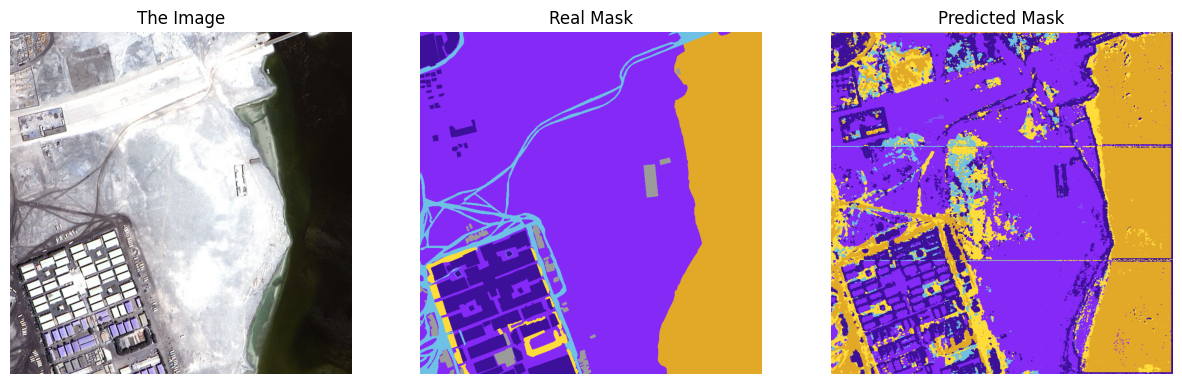

In [29]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

REAL_img = Image.open(REAL_img_path)
G_img = Image.open(msk_path)

patch_size = 256
SIZE_X = (REAL_img.size[0] // patch_size) * patch_size
SIZE_Y = (REAL_img.size[1] // patch_size) * patch_size
REAL_img = REAL_img.crop((0, 0, SIZE_X, SIZE_Y))
REAL_img = np.array(REAL_img)
REAL_img = np.array(REAL_img)


patch_size = 256
SIZE_X = (G_img.size[0] // patch_size) * patch_size
SIZE_Y = (G_img.size[1] // patch_size) * patch_size
G_img = G_img.crop((0, 0, SIZE_X, SIZE_Y))
G_img = np.array(G_img)


prediction = label_to_rgb(unpatched_prediction)

# Plot the images
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(REAL_img)
plt.title("The Image")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(G_img)
plt.title("Real Mask")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(prediction)
plt.title("Predicted Mask")
plt.axis('off')

plt.show()

In [30]:
import numpy as np
from PIL import Image

# Define the function to convert RGB mask to class labels
def rgb_to_2D_label(label, num_class=6):
    Building = np.array([60, 16, 152])
    Land = np.array([132, 41, 246])
    Road = np.array([110, 193, 228])
    Vegetation = np.array([254, 221, 58])
    Water = np.array([226, 169, 41])
    Unlabeled = np.array([155, 155, 155])

    label_seg = np.zeros(label.shape, dtype=np.uint8)
    label_seg[np.all(label == Building, axis=-1)] = 0
    label_seg[np.all(label == Land, axis=-1)] = 1
    label_seg[np.all(label == Road, axis=-1)] = 2
    label_seg[np.all(label == Vegetation, axis=-1)] = 3
    label_seg[np.all(label == Water, axis=-1)] = 4
    label_seg[np.all(label == Unlabeled, axis=-1)] = 5

    label_seg = label_seg[:, :, 0]
    return label_seg

# Define the metric functions
def global_accuracy(prediction, ground_truth):
    correct = np.sum(prediction == ground_truth)
    total = prediction.size
    return correct / total

def mean_iou(prediction, ground_truth, num_classes):
    iou_list = []
    for cls in range(num_classes):
        pred_cls = (prediction == cls)
        true_cls = (ground_truth == cls)
        intersection = np.logical_and(pred_cls, true_cls).sum()
        union = np.logical_or(pred_cls, true_cls).sum()
        if union == 0:
            iou = float('nan')
        else:
            iou = intersection / union
        iou_list.append(iou)
    return np.nanmean(iou_list)

def recall(prediction, ground_truth, num_classes):
    recall_list = []
    for cls in range(num_classes):
        pred_cls = (prediction == cls)
        true_cls = (ground_truth == cls)
        true_positive = np.logical_and(pred_cls, true_cls).sum()
        false_negative = true_cls.sum() - true_positive
        if true_cls.sum() == 0:
            recall_value = float('nan')
        else:
            recall_value = true_positive / (true_positive + false_negative)
        recall_list.append(recall_value)
    return np.nanmean(recall_list)

# Load the ground truth mask and convert it to class labels
ground_truth = np.array(Image.open(msk_path))
ground_truth = rgb_to_2D_label(ground_truth)  # Convert RGB to class labels

if unpatched_prediction.shape != ground_truth.shape:
    min_shape = np.minimum(unpatched_prediction.shape, ground_truth.shape)
    unpatched_prediction = unpatched_prediction[:min_shape[0], :min_shape[1]]
    ground_truth = ground_truth[:min_shape[0], :min_shape[1]]

pred_flat = unpatched_prediction.flatten()
gt_flat = ground_truth.flatten()


num_classes = 6

global_acc = global_accuracy(pred_flat, gt_flat)
mean_iou_val = mean_iou(pred_flat, gt_flat, num_classes)
recall_val = recall(pred_flat, gt_flat, num_classes)

print(f"Global Accuracy: {global_acc * 100:.2f}%")
print(f"Mean IoU: {mean_iou_val * 100:.2f}%")
print(f"Recall: {recall_val * 100:.2f}%")

Global Accuracy: 63.82%
Mean IoU: 26.40%
Recall: 39.75%


In [31]:
REAL_img_path = "/content/semantic-segmentation-of-aerial-imagery/Semantic segmentation dataset/Tile 1/images/image_part_005.jpg"
msk_path = "/content/semantic-segmentation-of-aerial-imagery/Semantic segmentation dataset/Tile 1/masks/image_part_005.png"

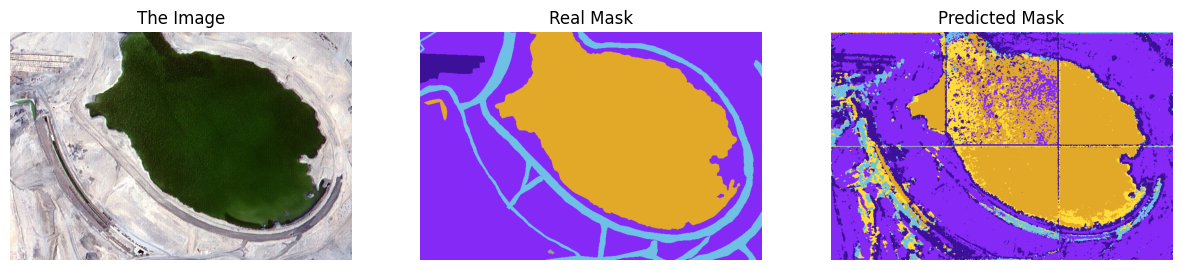

In [32]:
import torch
from torchvision import transforms
from PIL import Image
import numpy as np
from patchify import patchify, unpatchify
import matplotlib.pyplot as plt

model = SegNet(3, 6)
model.load_state_dict(torch.load(checkpoints_path, map_location=device))

transform = transforms.Compose([
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

img = Image.open(REAL_img_path)

patch_size = 256
SIZE_X = (img.size[0] // patch_size) * patch_size
SIZE_Y = (img.size[1] // patch_size) * patch_size
large_img = img.crop((0, 0, SIZE_X, SIZE_Y))
large_img = np.array(large_img)

patches_img = patchify(large_img, (patch_size, patch_size, 3), step=patch_size)
patches_img = patches_img[:, :, 0, :, :, :]

patched_prediction = []
for i in range(patches_img.shape[0]):
    for j in range(patches_img.shape[1]):
        single_patch_img = patches_img[i, j, :, :, :]
        single_patch_tensor = torch.from_numpy(single_patch_img).float()
        single_patch_tensor /= 255.0
        single_patch_tensor = single_patch_tensor.permute(2, 0, 1)

        single_patch_tensor = transform(single_patch_tensor).unsqueeze(0)

        with torch.no_grad():
            pred = model(single_patch_tensor)
        pred = torch.argmax(pred, dim=1).squeeze(0).cpu().numpy()
        patched_prediction.append(pred)

patched_prediction = np.array(patched_prediction)
patched_prediction = np.reshape(patched_prediction, [patches_img.shape[0], patches_img.shape[1], patch_size, patch_size])

unpatched_prediction = unpatchify(patched_prediction, (SIZE_Y, SIZE_X))

def label_to_rgb(predicted_image):

    Building = '#3C1098'.lstrip('#')
    Building = np.array(tuple(int(Building[i:i+2], 16) for i in (0, 2, 4))) # 60, 16, 152

    Land = '#8429F6'.lstrip('#')
    Land = np.array(tuple(int(Land[i:i+2], 16) for i in (0, 2, 4))) #132, 41, 246

    Road = '#6EC1E4'.lstrip('#')
    Road = np.array(tuple(int(Road[i:i+2], 16) for i in (0, 2, 4))) #110, 193, 228

    Vegetation =  'FEDD3A'.lstrip('#')
    Vegetation = np.array(tuple(int(Vegetation[i:i+2], 16) for i in (0, 2, 4))) #254, 221, 58

    Water = 'E2A929'.lstrip('#')
    Water = np.array(tuple(int(Water[i:i+2], 16) for i in (0, 2, 4))) #226, 169, 41

    Unlabeled = '#9B9B9B'.lstrip('#')
    Unlabeled = np.array(tuple(int(Unlabeled[i:i+2], 16) for i in (0, 2, 4))) #155, 155, 155


    segmented_img = np.empty((predicted_image.shape[0], predicted_image.shape[1], 3))

    segmented_img[(predicted_image == 0)] = Building
    segmented_img[(predicted_image == 1)] = Land
    segmented_img[(predicted_image == 2)] = Road
    segmented_img[(predicted_image == 3)] = Vegetation
    segmented_img[(predicted_image == 4)] = Water
    segmented_img[(predicted_image == 5)] = Unlabeled

    segmented_img = segmented_img.astype(np.uint8)
    return(segmented_img)

    from PIL import Image
import numpy as np
import matplotlib.pyplot as plt


# Load the images
REAL_img = Image.open(REAL_img_path)
G_img = Image.open(msk_path)


# Define patch size and adjust the size of G_img
patch_size = 256
SIZE_X = (REAL_img.size[0] // patch_size) * patch_size
SIZE_Y = (REAL_img.size[1] // patch_size) * patch_size
REAL_img = REAL_img.crop((0, 0, SIZE_X, SIZE_Y))
REAL_img = np.array(REAL_img)
REAL_img = np.array(REAL_img)


patch_size = 256
SIZE_X = (G_img.size[0] // patch_size) * patch_size
SIZE_Y = (G_img.size[1] // patch_size) * patch_size
G_img = G_img.crop((0, 0, SIZE_X, SIZE_Y))
G_img = np.array(G_img)


prediction = label_to_rgb(unpatched_prediction)

# Plot the images
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(REAL_img)
plt.title("The Image")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(G_img)
plt.title("Real Mask")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(prediction)
plt.title("Predicted Mask")
plt.axis('off')

plt.show()

In [33]:
import numpy as np
from PIL import Image

# Define the function to convert RGB mask to class labels
def rgb_to_2D_label(label, num_class=6):
    Building = np.array([60, 16, 152])
    Land = np.array([132, 41, 246])
    Road = np.array([110, 193, 228])
    Vegetation = np.array([254, 221, 58])
    Water = np.array([226, 169, 41])
    Unlabeled = np.array([155, 155, 155])

    label_seg = np.zeros(label.shape, dtype=np.uint8)
    label_seg[np.all(label == Building, axis=-1)] = 0
    label_seg[np.all(label == Land, axis=-1)] = 1
    label_seg[np.all(label == Road, axis=-1)] = 2
    label_seg[np.all(label == Vegetation, axis=-1)] = 3
    label_seg[np.all(label == Water, axis=-1)] = 4
    label_seg[np.all(label == Unlabeled, axis=-1)] = 5

    label_seg = label_seg[:, :, 0]
    return label_seg

# Define the metric functions
def global_accuracy(prediction, ground_truth):
    correct = np.sum(prediction == ground_truth)
    total = prediction.size
    return correct / total

def mean_iou(prediction, ground_truth, num_classes):
    iou_list = []
    for cls in range(num_classes):
        pred_cls = (prediction == cls)
        true_cls = (ground_truth == cls)
        intersection = np.logical_and(pred_cls, true_cls).sum()
        union = np.logical_or(pred_cls, true_cls).sum()
        if union == 0:
            iou = float('nan')
        else:
            iou = intersection / union
        iou_list.append(iou)
    return np.nanmean(iou_list)

def recall(prediction, ground_truth, num_classes):
    recall_list = []
    for cls in range(num_classes):
        pred_cls = (prediction == cls)
        true_cls = (ground_truth == cls)
        true_positive = np.logical_and(pred_cls, true_cls).sum()
        false_negative = true_cls.sum() - true_positive
        if true_cls.sum() == 0:
            recall_value = float('nan')
        else:
            recall_value = true_positive / (true_positive + false_negative)
        recall_list.append(recall_value)
    return np.nanmean(recall_list)

# Load the ground truth mask and convert it to class labels
ground_truth = np.array(Image.open(msk_path))
ground_truth = rgb_to_2D_label(ground_truth)  # Convert RGB to class labels

# Ensure the prediction and ground truth have the same shape
if unpatched_prediction.shape != ground_truth.shape:
    min_shape = np.minimum(unpatched_prediction.shape, ground_truth.shape)
    unpatched_prediction = unpatched_prediction[:min_shape[0], :min_shape[1]]
    ground_truth = ground_truth[:min_shape[0], :min_shape[1]]

# Flatten the arrays for easier comparison
pred_flat = unpatched_prediction.flatten()
gt_flat = ground_truth.flatten()

# Number of classes
num_classes = 6

# Calculate metrics
global_acc = global_accuracy(pred_flat, gt_flat)
mean_iou_val = mean_iou(pred_flat, gt_flat, num_classes)
recall_val = recall(pred_flat, gt_flat, num_classes)

print(f"Global Accuracy: {global_acc * 100:.2f}%")
print(f"Mean IoU: {mean_iou_val * 100:.2f}%")
print(f"Recall: {recall_val * 100:.2f}%")

Global Accuracy: 63.30%
Mean IoU: 23.89%
Recall: 43.49%
